Based on the given attributes of meters, we'll develope models according to defined aggregation levels:
- City-level
- Block-level
- House-level

**How does aggregation levels affect prediction accuracy? Average MSE and R2 of each aggregation level?**

Try to caculate MSE and R2 for at least one meter of each level.

If possible, plot distribution plot or boxplot of multiple samples in each level.

## 1. Import pakages

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

import os
import tqdm
import requests
from datetime import datetime, timedelta
import time

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn import preprocessing

import lightgbm as lgb

## 2. Data reading and preprocessing

In [2]:
path_dataset=r'C:\Users\patri\Buildsys_Tutorial\dataset'
os.listdir(path_dataset)

['acorn_details.csv',
 'daily_dataset.csv',
 'darksky_parameters_documentation.html',
 'elec_block.csv',
 'elec_city.csv',
 'elec_house.csv',
 'halfhourly_dataset',
 'informations_households.csv',
 'uk_bank_holidays.csv',
 'weather_daily_darksky.csv',
 'weather_hourly_darksky.csv']

In [3]:
informations_households = pd.read_csv(os.path.join(path_dataset,'informations_households.csv'))
informations_households

,LCLid,stdorToU,Acorn,Acorn_grouped,file
0,MAC005492,ToU,ACORN-,ACORN-,block_0
1,MAC001074,ToU,ACORN-,ACORN-,block_0
2,MAC000002,Std,ACORN-A,Affluent,block_0
3,MAC003613,Std,ACORN-A,Affluent,block_0
4,MAC003597,Std,ACORN-A,Affluent,block_0
...,...,...,...,...,...
5561,MAC002056,Std,ACORN-U,ACORN-U,block_111
5562,MAC004587,Std,ACORN-U,ACORN-U,block_111
5563,MAC004828,Std,ACORN-U,ACORN-U,block_111
5564,MAC001704,ToU,ACORN-U,ACORN-U,block_111


### 2.1 Energy data

In [4]:
elec_house = pd.read_csv(os.path.join(path_dataset,'elec_house.csv'),index_col='tstp',parse_dates=True)
elec_block = pd.read_csv(os.path.join(path_dataset,'elec_block.csv'),index_col='tstp',parse_dates=True)
elec_city = pd.read_csv(os.path.join(path_dataset,'elec_city.csv'),index_col='tstp',parse_dates=True).rename(columns={'energy(kWh/hh)':'London'})

<AxesSubplot:title={'center':'Average of electricity consumption in London'}, xlabel='tstp'>

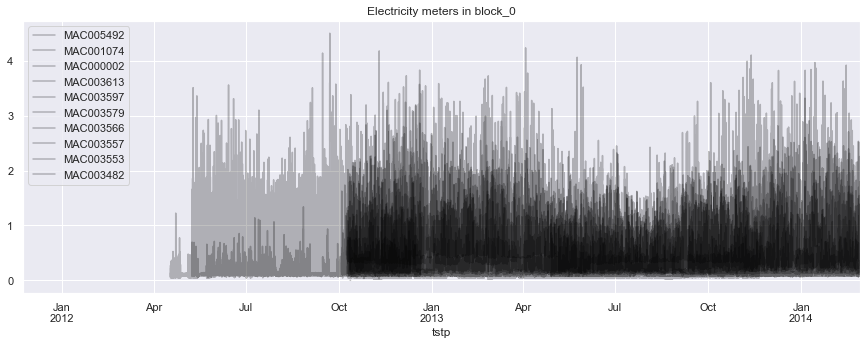

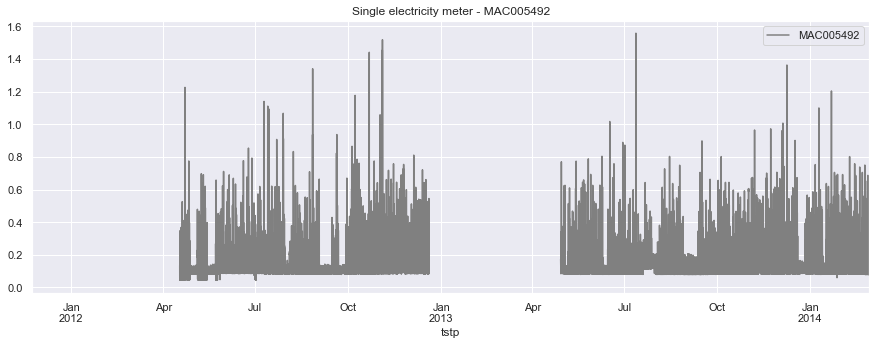

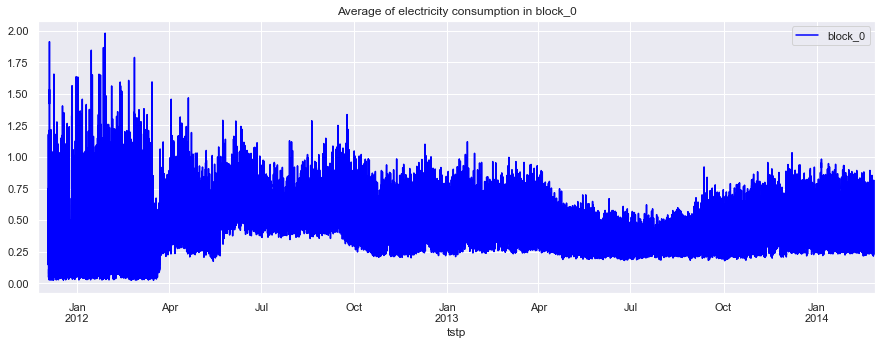

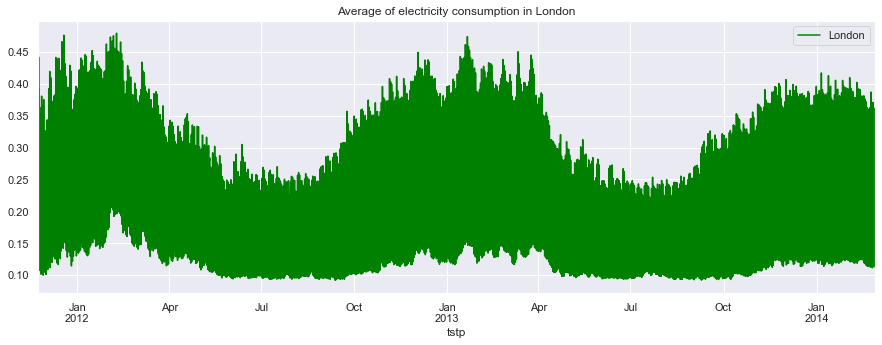

In [5]:
target_house = 'MAC005492'
target_block = 'block_0'

list_LCLid = informations_households.loc[informations_households['file']==target_block, 'LCLid'].to_list()

elec_house[list_LCLid[:10]].plot(figsize=(15,5),color='black',alpha=0.25,title='Electricity meters in '+target_block)
elec_house[[target_house]].plot(figsize=(15,5),color='grey',title='Single electricity meter - '+target_house)
elec_block[[target_block]].plot(figsize=(15,5),color='blue',title='Average of electricity consumption in '+target_block)
elec_city[['London']].plot(figsize=(15,5),color='green',title='Average of electricity consumption in London')

### 2.2 Weather data

In [6]:
weather_hourly_darksky = pd.read_csv(os.path.join(path_dataset,'weather_hourly_darksky.csv'),index_col='time',parse_dates=True)

In [7]:
temperatureData = weather_hourly_darksky['temperature']

### 2.3 Calendar data

In [8]:
df_holiday = pd.read_csv(os.path.join(path_dataset,'uk_bank_holidays.csv'))
df_holiday['Bank holidays'] = pd.to_datetime(df_holiday['Bank holidays'])
df_holiday = df_holiday.rename(columns={'Bank holidays':'date','Type':'Holiday'})

In [9]:
calendar_encoder = preprocessing.LabelEncoder()
df_holiday['Holiday'] = calendar_encoder.fit_transform(df_holiday['Holiday'])

## 3. Forecasting model of city-wide electricity

In [10]:
# Prepare dataset
df_dataset = elec_city.copy()
df_dataset.columns = 'elec_'+df_dataset.columns

df_dataset['timestamp'] = df_dataset.index
df_dataset['date'] = pd.to_datetime(df_dataset.index.date)
df_dataset['year'] = df_dataset.index.year.astype('int')
df_dataset['weekday'] = df_dataset.index.weekday
df_dataset['hour'] = df_dataset.index.hour + df_dataset.index.minute/60
df_dataset['timeofweek'] = df_dataset['hour'] + df_dataset['weekday']*24

df_dataset = df_dataset.merge(temperatureData, left_index=True, right_index=True)
df_dataset['kWh_yesterday'] = df_dataset['elec_London'].shift(24)
df_dataset['kWh_lastweek'] = df_dataset['elec_London'].shift(7*24)

df_dataset = df_dataset.merge(df_holiday, on='date', how='left')
df_dataset = df_dataset.drop('date',axis=1)

df_dataset['Holiday'] = df_dataset['Holiday'].fillna(-1)

df_dataset.set_index('timestamp',inplace=True)

df_dataset = df_dataset.dropna()

df_dataset

,elec_London,year,weekday,hour,timeofweek,temperature,kWh_yesterday,kWh_lastweek,Holiday
timestamp,,,,,,,,,
2011-11-30 09:00:00,0.171109,2011,2,9.0,57.0,7.66,0.172727,0.284500,-1.0
2011-11-30 10:00:00,0.180348,2011,2,10.0,58.0,9.73,0.166228,0.153333,-1.0
2011-11-30 11:00:00,0.156176,2011,2,11.0,59.0,11.29,0.156828,0.110286,-1.0
2011-11-30 12:00:00,0.192500,2011,2,12.0,60.0,11.87,0.163864,0.394222,-1.0
2011-11-30 13:00:00,0.170288,2011,2,13.0,61.0,11.67,0.219574,0.258333,-1.0
...,...,...,...,...,...,...,...,...,...
2014-02-27 20:00:00,0.347004,2014,3,20.0,92.0,5.94,0.356948,0.341839,-1.0
2014-02-27 21:00:00,0.334706,2014,3,21.0,93.0,5.03,0.328457,0.324759,-1.0
2014-02-27 22:00:00,0.299760,2014,3,22.0,94.0,4.10,0.294799,0.295767,-1.0


In [11]:
elec_city

,London
tstp,
2011-11-23 09:00:00,0.284500
2011-11-23 09:30:00,0.280500
2011-11-23 10:00:00,0.153333
2011-11-23 10:30:00,0.098000
2011-11-23 11:00:00,0.110286
...,...
2014-02-27 22:00:00,0.299760
2014-02-27 22:30:00,0.285163
2014-02-27 23:00:00,0.252274


In [11]:
list_feat = ['weekday','hour','temperature',
             'Holiday',
             'kWh_yesterday']

In [12]:
# Data split (training:2013-01~2013-06; test:2013-07~present)
traindata = df_dataset.loc['2013-01':'2013-06'].copy()
testdata = df_dataset.loc['2013-07':].copy()

LGB_model = lgb.LGBMRegressor()
LGB_model.fit(traindata[list_feat], traindata['elec_London'])

testdata['elec_London_pred'] = LGB_model.predict(testdata[list_feat])

errors = abs(testdata['elec_London_pred'] - testdata['elec_London'])

RSQUARED = r2_score(testdata['elec_London'], testdata['elec_London_pred'])
MAE = mean_absolute_error(testdata['elec_London'], testdata['elec_London_pred'])
MAPE = mean_absolute_percentage_error(testdata['elec_London'], testdata['elec_London_pred'])

print("R SQUARED: "+str(round(RSQUARED,3)))
print("MAE: "+str(round(MAE,3)))
print("MAPE: "+str(round(MAPE,3)))

#testdata[['elec_London', 'elec_London_pred']].iplot()
#testdata[['elec_London', 'elec_London_pred']].plot(figsize=(15,3))
#plt.legend(bbox_to_anchor=(1.00, 1.00))

R SQUARED: 0.97
MAE: 0.008
MAPE: 0.037


In [13]:
city_error = pd.DataFrame(data=['city','city_London',RSQUARED,MAE,MAPE],index=['agg_level','id','RSQUARED','MAE','MAPE']).T
city_error[['RSQUARED','MAE','MAPE']] = city_error[['RSQUARED','MAE','MAPE']].astype('float')
city_error

,agg_level,id,RSQUARED,MAE,MAPE
0,city,city_London,0.970257,0.008185,0.037471


## 4. Forecasting models of block electricity meters

In [14]:
# Prepare dataset
df_dataset = elec_block.copy()

df_dataset['timestamp'] = df_dataset.index
df_dataset['date'] = pd.to_datetime(df_dataset.index.date)
df_dataset['year'] = df_dataset.index.year.astype('int')
df_dataset['weekday'] = df_dataset.index.weekday
df_dataset['hour'] = df_dataset.index.hour + df_dataset.index.minute/60
df_dataset['timeofweek'] = df_dataset['hour'] + df_dataset['weekday']*24

df_dataset = df_dataset.merge(temperatureData, left_index=True, right_index=True)

df_dataset = df_dataset.merge(df_holiday, on='date', how='left')
df_dataset = df_dataset.drop('date',axis=1)

df_dataset['Holiday'] = df_dataset['Holiday'].fillna(-1)

df_dataset = df_dataset.melt(id_vars = ['timestamp', 'year', 'weekday', 'hour', 'timeofweek', 'temperature', 'Holiday'], 
                             var_name='block',
                             value_name='elec')
df_dataset['block'] = df_dataset['block'].str.split('_',expand=True).iloc[:,-1].astype('int')

df_dataset['kWh_yesterday'] = df_dataset['elec'].shift(24)
df_dataset['kWh_lastweek'] = df_dataset['elec'].shift(7*24)

df_dataset.loc[df_dataset['block']!=df_dataset['block'].shift(24),'kWh_yesterday'] = np.nan
df_dataset.loc[df_dataset['block']!=df_dataset['block'].shift(7*24),'kWh_lastweek'] = np.nan

df_dataset = df_dataset.dropna()

df_dataset

,timestamp,year,weekday,hour,timeofweek,temperature,Holiday,block,elec,kWh_yesterday,kWh_lastweek
408,2011-12-10 09:00:00,2011,5,9.0,129.0,0.84,-1.0,0,0.415000,0.196000,0.149000
409,2011-12-10 10:00:00,2011,5,10.0,130.0,2.43,-1.0,0,0.815000,0.099000,0.768000
410,2011-12-10 11:00:00,2011,5,11.0,131.0,4.67,-1.0,0,0.628000,0.126000,0.588000
411,2011-12-10 12:00:00,2011,5,12.0,132.0,6.08,-1.0,0,0.077000,0.088000,0.843000
412,2011-12-10 13:00:00,2011,5,13.0,133.0,5.59,-1.0,0,0.071000,0.078000,0.120000
...,...,...,...,...,...,...,...,...,...,...,...
2224539,2014-02-27 20:00:00,2014,3,20.0,92.0,5.94,-1.0,99,0.234354,0.210437,0.231646
2224540,2014-02-27 21:00:00,2014,3,21.0,93.0,5.03,-1.0,99,0.226812,0.162937,0.219958
2224541,2014-02-27 22:00:00,2014,3,22.0,94.0,4.10,-1.0,99,0.181979,0.150646,0.208417
2224542,2014-02-27 23:00:00,2014,3,23.0,95.0,3.93,-1.0,99,0.166396,0.148104,0.209542


In [15]:
block_error=[]

for block in df_dataset['block'].unique():
    print('block: '+str(block))
    df_dataset_temp = df_dataset[df_dataset['block']==block].copy()

# Data split (training:2013-01~2013-06; test:2013-07~present)
    traindata = df_dataset_temp.set_index('timestamp').loc['2013-01':'2013-06'].copy()
    testdata = df_dataset_temp.set_index('timestamp').loc['2013-07':].copy()

# Create forecasting model
    LGB_model = lgb.LGBMRegressor()
    LGB_model.fit(traindata[list_feat], traindata['elec'])

    testdata['elec_pred'] = LGB_model.predict(testdata[list_feat])

    errors = abs(testdata['elec_pred'] - testdata['elec'])

    RSQUARED = r2_score(testdata['elec'], testdata['elec_pred'])
    MAE = mean_absolute_error(testdata['elec'], testdata['elec_pred'])
    MAPE = mean_absolute_percentage_error(testdata['elec'], testdata['elec_pred'])

    print("R SQUARED: "+str(round(RSQUARED,3)))
    print("MAE: "+str(round(MAE,3)))
    print("MAPE: "+str(round(MAPE,3)))
    print('-----------------------------------------')

    #testdata[['elec', 'elec_pred']].plot(figsize=(15,3))
    #plt.legend(bbox_to_anchor=(1.00, 1.00))
    
    block_error_temp = pd.DataFrame(data=['block','block_'+str(int(block)),RSQUARED,MAE,MAPE],index=['agg_level','id','RSQUARED','MAE','MAPE']).T
    block_error.append(block_error_temp)

block: 0
R SQUARED: 0.88
MAE: 0.04
MAPE: 0.092
-----------------------------------------
block: 1
R SQUARED: 0.877
MAE: 0.04
MAPE: 0.103
-----------------------------------------
block: 10
R SQUARED: 0.849
MAE: 0.033
MAPE: 0.124
-----------------------------------------
block: 100
R SQUARED: 0.738
MAE: 0.025
MAPE: 0.149
-----------------------------------------
block: 101
R SQUARED: 0.811
MAE: 0.021
MAPE: 0.119
-----------------------------------------
block: 102
R SQUARED: 0.778
MAE: 0.016
MAPE: 0.122
-----------------------------------------
block: 103
R SQUARED: 0.583
MAE: 0.023
MAPE: 0.16
-----------------------------------------
block: 104
R SQUARED: 0.748
MAE: 0.028
MAPE: 0.135
-----------------------------------------
block: 105
R SQUARED: 0.739
MAE: 0.02
MAPE: 0.121
-----------------------------------------
block: 106
R SQUARED: 0.796
MAE: 0.017
MAPE: 0.11
-----------------------------------------
block: 107
R SQUARED: 0.789
MAE: 0.021
MAPE: 0.125
------------------------------

R SQUARED: 0.847
MAE: 0.024
MAPE: 0.111
-----------------------------------------
block: 81
R SQUARED: 0.855
MAE: 0.024
MAPE: 0.106
-----------------------------------------
block: 82
R SQUARED: 0.834
MAE: 0.023
MAPE: 0.112
-----------------------------------------
block: 83
R SQUARED: 0.881
MAE: 0.023
MAPE: 0.105
-----------------------------------------
block: 84
R SQUARED: 0.829
MAE: 0.024
MAPE: 0.114
-----------------------------------------
block: 85
R SQUARED: 0.852
MAE: 0.023
MAPE: 0.111
-----------------------------------------
block: 86
R SQUARED: 0.819
MAE: 0.021
MAPE: 0.106
-----------------------------------------
block: 87
R SQUARED: 0.852
MAE: 0.021
MAPE: 0.121
-----------------------------------------
block: 88
R SQUARED: 0.847
MAE: 0.022
MAPE: 0.113
-----------------------------------------
block: 89
R SQUARED: 0.813
MAE: 0.023
MAPE: 0.119
-----------------------------------------
block: 9
R SQUARED: 0.859
MAE: 0.029
MAPE: 0.119
-----------------------------------------

In [16]:
block_error = pd.concat(block_error,axis=0,ignore_index=True)
block_error[['RSQUARED','MAE','MAPE']] = block_error[['RSQUARED','MAE','MAPE']].astype('float')
block_error

,agg_level,id,RSQUARED,MAE,MAPE
0,block,block_0,0.880371,0.040126,0.092020
1,block,block_1,0.877414,0.040036,0.102653
2,block,block_10,0.849055,0.032968,0.124043
3,block,block_100,0.738338,0.024744,0.149448
4,block,block_101,0.810675,0.020688,0.119054
...,...,...,...,...,...
107,block,block_95,0.817626,0.019327,0.127430
108,block,block_96,0.795336,0.016735,0.123004
109,block,block_97,0.804553,0.018223,0.106470
110,block,block_98,0.756519,0.018709,0.118123


## 5. Forecasting models of house electricity meters

In [17]:
# Prepare dataset
df_dataset = elec_house.copy()
df_dataset = df_dataset.loc['2013':]
df_dataset = df_dataset.loc[:, df_dataset.isna().mean()<0.5]
df_dataset = df_dataset.sample(n=100,axis=1,random_state=42).copy()

df_dataset['timestamp'] = df_dataset.index
df_dataset['date'] = pd.to_datetime(df_dataset.index.date)
df_dataset['year'] = df_dataset.index.year.astype('int')
df_dataset['weekday'] = df_dataset.index.weekday
df_dataset['hour'] = df_dataset.index.hour + df_dataset.index.minute/60
df_dataset['timeofweek'] = df_dataset['hour'] + df_dataset['weekday']*24

df_dataset = df_dataset.merge(temperatureData, left_index=True, right_index=True)

df_dataset = df_dataset.merge(df_holiday, on='date', how='left')
df_dataset = df_dataset.drop('date',axis=1)

df_dataset['Holiday'] = df_dataset['Holiday'].fillna(-1)


df_dataset = df_dataset.melt(id_vars = ['timestamp', 'year', 'weekday', 'hour', 'timeofweek', 'temperature', 'Holiday'], 
                             var_name='house',
                             value_name='elec')
df_dataset['house'] = df_dataset['house'].str.split('C',expand=True).iloc[:,-1].astype('int')

df_dataset['kWh_yesterday'] = df_dataset['elec'].shift(24)
df_dataset['kWh_lastweek'] = df_dataset['elec'].shift(7*24)

df_dataset.loc[df_dataset['house']!=df_dataset['house'].shift(24),'kWh_yesterday'] = np.nan
df_dataset.loc[df_dataset['house']!=df_dataset['house'].shift(7*24),'kWh_lastweek'] = np.nan

df_dataset = df_dataset.dropna()

df_dataset

,timestamp,year,weekday,hour,timeofweek,temperature,Holiday,house,elec,kWh_yesterday,kWh_lastweek
168,2013-01-08 00:00:00,2013,1,0.0,24.0,9.08,-1.0,448,0.016,0.093,0.098
169,2013-01-08 01:00:00,2013,1,1.0,25.0,9.10,-1.0,448,0.043,0.064,0.066
170,2013-01-08 02:00:00,2013,1,2.0,26.0,9.11,-1.0,448,0.085,0.009,0.010
171,2013-01-08 03:00:00,2013,1,3.0,27.0,9.24,-1.0,448,0.010,0.010,0.009
172,2013-01-08 04:00:00,2013,1,4.0,28.0,9.62,-1.0,448,0.010,0.010,0.065
...,...,...,...,...,...,...,...,...,...,...,...
1015095,2014-02-27 20:00:00,2014,3,20.0,92.0,5.94,-1.0,4531,0.480,0.395,0.152
1015096,2014-02-27 21:00:00,2014,3,21.0,93.0,5.03,-1.0,4531,0.248,0.307,0.206
1015097,2014-02-27 22:00:00,2014,3,22.0,94.0,4.10,-1.0,4531,0.213,0.226,0.234
1015098,2014-02-27 23:00:00,2014,3,23.0,95.0,3.93,-1.0,4531,0.215,0.215,0.196


In [18]:
house_error=[]

for house in df_dataset['house'].unique():
    print('house: '+str(house))
    df_dataset_temp = df_dataset[df_dataset['house']==house].copy()

# Data split (training:2013-01~2013-06; test:2013-07~present)
    traindata = df_dataset_temp.set_index('timestamp').loc['2013-01':'2013-06'].copy()
    testdata = df_dataset_temp.set_index('timestamp').loc['2013-07':].copy()

# Create forecasting model
    LGB_model = lgb.LGBMRegressor()
    LGB_model.fit(traindata[list_feat], traindata['elec'])

    testdata['elec_pred'] = LGB_model.predict(testdata[list_feat])

    errors = abs(testdata['elec_pred'] - testdata['elec'])

    RSQUARED = r2_score(testdata['elec'], testdata['elec_pred'])
    MAE = mean_absolute_error(testdata['elec'], testdata['elec_pred'])
    MAPE = mean_absolute_percentage_error(testdata['elec'], testdata['elec_pred'])

    print("R SQUARED: "+str(round(RSQUARED,3)))
    print("MAE: "+str(round(MAE,3)))
    print("MAPE: "+str(round(MAPE,3)))
    print('-----------------------------------------')

    #testdata[['elec', 'elec_pred']].plot(figsize=(15,3))
    #plt.legend(bbox_to_anchor=(1.00, 1.00))
    
    house_error_temp = pd.DataFrame(data=['house','house_'+str(int(house)),RSQUARED,MAE,MAPE],index=['agg_level','id','RSQUARED','MAE','MAPE']).T
    house_error.append(house_error_temp)

house: 448
R SQUARED: 0.052
MAE: 0.07
MAPE: 354110578609.021
-----------------------------------------
house: 1170
R SQUARED: -0.069
MAE: 0.132
MAPE: 1440049664000.89
-----------------------------------------
house: 857
R SQUARED: 0.18
MAE: 0.035
MAPE: 0.726
-----------------------------------------
house: 4473
R SQUARED: 0.15
MAE: 0.089
MAPE: 1.181
-----------------------------------------
house: 5446
R SQUARED: 0.298
MAE: 0.251
MAPE: 2.699
-----------------------------------------
house: 4890
R SQUARED: 0.093
MAE: 0.173
MAPE: 0.65
-----------------------------------------
house: 1632
R SQUARED: 0.101
MAE: 0.049
MAPE: 0.914
-----------------------------------------
house: 2682
R SQUARED: 0.326
MAE: 0.094
MAPE: 0.496
-----------------------------------------
house: 3441
R SQUARED: 0.272
MAE: 0.155
MAPE: 22833485506104.914
-----------------------------------------
house: 626
R SQUARED: 0.332
MAE: 0.048
MAPE: 724926636076.425
-----------------------------------------
house: 3824
R SQUARE

R SQUARED: 0.077
MAE: 0.056
MAPE: 0.293
-----------------------------------------
house: 1967
R SQUARED: -0.668
MAE: 0.049
MAPE: 1.286
-----------------------------------------
house: 3908
R SQUARED: 0.058
MAE: 0.061
MAPE: 1.322
-----------------------------------------
house: 4692
R SQUARED: -0.029
MAE: 0.139
MAPE: 0.91
-----------------------------------------
house: 2765
R SQUARED: -0.01
MAE: 0.166
MAPE: 0.944
-----------------------------------------
house: 518
R SQUARED: 0.195
MAE: 0.079
MAPE: 1.042
-----------------------------------------
house: 5262
R SQUARED: -0.099
MAE: 0.051
MAPE: 0.715
-----------------------------------------
house: 5362
R SQUARED: 0.317
MAE: 0.061
MAPE: 0.936
-----------------------------------------
house: 5104
R SQUARED: 0.18
MAE: 0.015
MAPE: 0.233
-----------------------------------------
house: 4654
R SQUARED: 0.057
MAE: 0.105
MAPE: 0.313
-----------------------------------------
house: 2907
R SQUARED: 0.023
MAE: 0.131
MAPE: 0.644
--------------------

In [19]:
house_error = pd.concat(house_error,axis=0,ignore_index=True)
house_error[['RSQUARED','MAE','MAPE']] = house_error[['RSQUARED','MAE','MAPE']].astype('float')
house_error

,agg_level,id,RSQUARED,MAE,MAPE
0,house,house_448,0.051998,0.069997,3.541106e+11
1,house,house_1170,-0.068526,0.131950,1.440050e+12
2,house,house_857,0.179997,0.034563,7.263346e-01
3,house,house_4473,0.149710,0.088530,1.181091e+00
4,house,house_5446,0.297993,0.251274,2.698843e+00
...,...,...,...,...,...
95,house,house_4654,0.057342,0.105434,3.126452e-01
96,house,house_2907,0.022824,0.130868,6.438269e-01
97,house,house_2623,0.114977,0.071888,1.160714e+00
98,house,house_4869,0.266321,0.105922,7.639198e-01


In [20]:
df_error = pd.concat([city_error,block_error,house_error],axis=0,ignore_index=True)

for agg_level in df_error['agg_level'].unique():
    for metric in ['RSQUARED','MAE','MAPE']:
        df_temp = df_error.loc[df_error['agg_level']==agg_level, metric]
        quantile_75 = df_temp.quantile(0.75)
        quantile_25 = df_temp.quantile(0.25)
        IQR = quantile_75 - quantile_25
        
        df_error.loc[(df_error['agg_level']==agg_level)&(df_error[metric]>quantile_75+1.5*IQR), metric] = np.nan
        df_error.loc[(df_error['agg_level']==agg_level)&(df_error[metric]<quantile_25-1.5*IQR), metric] = np.nan
        
df_error

,agg_level,id,RSQUARED,MAE,MAPE
0,city,city_London,0.970257,0.008185,0.037471
1,block,block_0,0.880371,NaN,0.092020
2,block,block_1,0.877414,NaN,0.102653
3,block,block_10,0.849055,0.032968,0.124043
4,block,block_100,0.738338,0.024744,0.149448
...,...,...,...,...,...
208,house,house_4654,0.057342,0.105434,0.312645
209,house,house_2907,0.022824,0.130868,0.643827
210,house,house_2623,0.114977,0.071888,1.160714
211,house,house_4869,0.266321,0.105922,0.763920


agg_level,city,block,house
MAE,0.008185,0.024762,0.087520
MAPE,0.037471,0.122757,0.757291
RSQUARED,0.970257,0.822650,0.181673


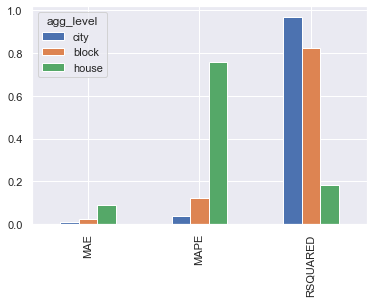

In [21]:
df_error.pivot_table(columns='agg_level',values=['RSQUARED','MAE','MAPE'])[['city','block','house']].plot(kind='bar')
display(df_error.pivot_table(columns='agg_level',values=['RSQUARED','MAE','MAPE'])[['city','block','house']])

## 6. Comparison of errors between different aggregation levels

C:\Users\patri\AppData\Roaming\Python\Python37\site-packages\seaborn\categorical.py:1282: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
C:\Users\patri\AppData\Roaming\Python\Python37\site-packages\seaborn\categorical.py:1286: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter
C:\Users\patri\AppData\Roaming\Python\Python37\site-packages\seaborn\categorical.py:1296: UserWarning: 26.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


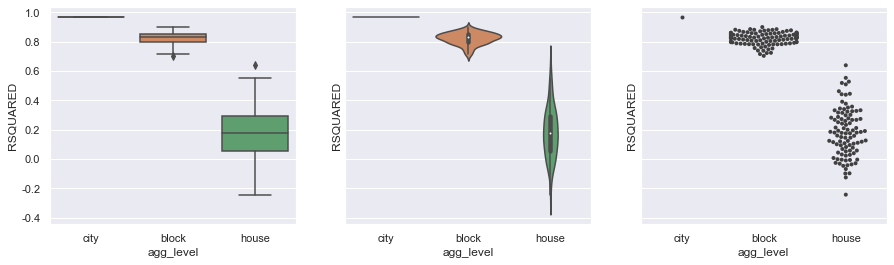

C:\Users\patri\AppData\Roaming\Python\Python37\site-packages\seaborn\categorical.py:1282: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
C:\Users\patri\AppData\Roaming\Python\Python37\site-packages\seaborn\categorical.py:1286: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter
C:\Users\patri\AppData\Roaming\Python\Python37\site-packages\seaborn\categorical.py:1296: UserWarning: 43.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


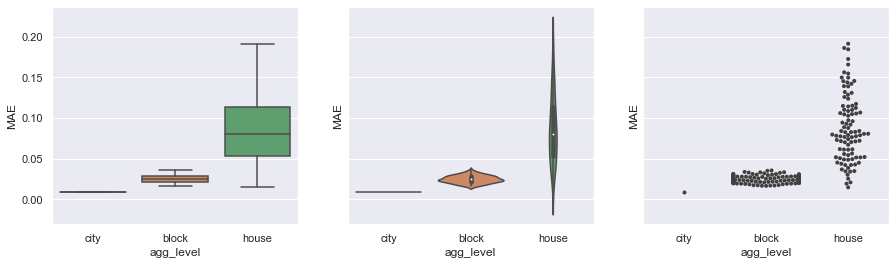

C:\Users\patri\AppData\Roaming\Python\Python37\site-packages\seaborn\categorical.py:1282: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
C:\Users\patri\AppData\Roaming\Python\Python37\site-packages\seaborn\categorical.py:1286: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter
C:\Users\patri\AppData\Roaming\Python\Python37\site-packages\seaborn\categorical.py:1296: UserWarning: 71.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


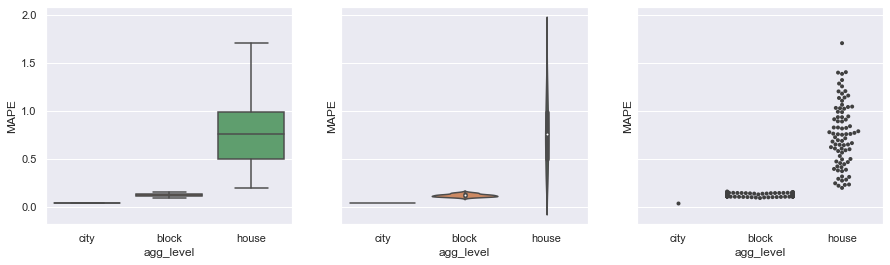

In [22]:
for metric in ['RSQUARED','MAE','MAPE']:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
    sns.boxplot(x="agg_level", y=metric, data=df_error,ax=axes[0])
    sns.violinplot(x="agg_level", y=metric, data=df_error,ax=axes[1])
    sns.swarmplot(x="agg_level", y=metric, data=df_error, size=4, color=".25",ax=axes[2])
    plt.show()